# Librerias

In [2]:
import configparser
import pandas as pd
import pymysql
import re
from sqlalchemy import create_engine, text

# Configuracion de parámetros

In [46]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

# Configuración a Base de datos

In [4]:
MySQL_sakila = pymysql.connect(
    host=config['local_mysql']['HOST'],
    user=config['local_mysql']['USER'],
    password=config['local_mysql']['PASS'],
    database=config['local_mysql']['DB_NAME'],
    port=int(config['local_mysql']['PORT'])
)

In [47]:
staging_conn_str = (
    f"postgresql://{config['local_postgres']['USER']}:"
    f"{config['local_postgres']['PASS']}@"
    f"{config['local_postgres']['HOST']}:"
    f"{config['local_postgres']['PORT']}/"
    f"{config['local_postgres']['DB_NAME']}"
)
staging_engine = create_engine(staging_conn_str)

# Creación del schema para staging en PostgreSQL

In [8]:
SCHEMA = config['local_postgres']['SCHEMA']

with staging_engine.connect() as conn:
    conn = conn.execution_options(isolation_level="AUTOCOMMIT")
    result = conn.execute(text(f"SELECT schema_name FROM information_schema.schemata WHERE schema_name = '{SCHEMA}'"))
    if result.fetchone() is None:
        conn.execute(text(f"CREATE SCHEMA {SCHEMA};"))
        print(f"Esquema '{SCHEMA}' creado exitosamente.")
    else:
        print(f"Esquema '{SCHEMA}' ya existe.")

Esquema 'staging_sakila' ya existe.


# Extracción de la data de MySQL a PostgreSQL

In [9]:
sakila_curor = MySQL_sakila.cursor()
sakila_curor.execute("SHOW TABLES;")
tables = [table[0] for table in sakila_curor.fetchall()]
print(tables)

InterfaceError: (0, '')

## Insertamos la data en la base de datos de PostgreSQL [STAGING]

In [ ]:
for table in tables:
    sql_query = f'SELECT * FROM {table}'
    sakila_df = pd.read_sql(sql_query, MySQL_sakila)

    for col in sakila_df.columns:
        if sakila_df[col].dtype == object and isinstance(sakila_df[col].iloc[0], set):
            sakila_df[col] = sakila_df[col].apply(lambda x: ','.join(x) if isinstance(x, set) else x)

    sakila_df.to_sql(table, staging_engine, schema=SCHEMA, if_exists='append', index=False)
    print(f"Tabla '{table}' insertada exitosamente en PostgreSQL.")

print("Proceso completado.")

C:\Users\maria\AppData\Local\Temp\ipykernel_13008\3641891769.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sakila_df = pd.read_sql(sql_query, MySQL_sakila)


Tabla 'actor' insertada exitosamente en PostgreSQL.
Tabla 'actor_info' insertada exitosamente en PostgreSQL.
Tabla 'address' insertada exitosamente en PostgreSQL.
Tabla 'category' insertada exitosamente en PostgreSQL.
Tabla 'city' insertada exitosamente en PostgreSQL.
Tabla 'country' insertada exitosamente en PostgreSQL.
Tabla 'customer' insertada exitosamente en PostgreSQL.
Tabla 'customer_list' insertada exitosamente en PostgreSQL.
Tabla 'film' insertada exitosamente en PostgreSQL.
Tabla 'film_actor' insertada exitosamente en PostgreSQL.
Tabla 'film_category' insertada exitosamente en PostgreSQL.
Tabla 'film_list' insertada exitosamente en PostgreSQL.
Tabla 'film_text' insertada exitosamente en PostgreSQL.
Tabla 'inventory' insertada exitosamente en PostgreSQL.
Tabla 'language' insertada exitosamente en PostgreSQL.
Tabla 'nicer_but_slower_film_list' insertada exitosamente en PostgreSQL.
Tabla 'payment' insertada exitosamente en PostgreSQL.
Tabla 'rental' insertada exitosamente en Pos

## Cierre de conexiones MySQL

In [6]:
MySQL_sakila.close()
sakila_curor.close()

NameError: name 'sakila_curor' is not defined

# Datamart

In [49]:
staging_queries = configparser.ConfigParser()
staging_queries.read('queries.ini')

stage_queries = {
  'TblDim_Cliente': staging_queries['staging_queries']['DIM_CLIENTES'],
  'TblDim_Pelicula': staging_queries['staging_queries']['DIM_PELICULA'],
  'TblDim_Pagos': staging_queries['staging_queries']['DIM_PAGOS'],
  'TblDim_Actores': staging_queries['staging_queries']['DIM_ACTORES'],
  'Tbl_Alquiler': staging_queries['staging_queries']['DIM_ALQUILER'],
}

In [50]:
SCHEMA = config['local_postgres']['SCHEMA']

with staging_engine.connect() as conn:
    conn = conn.execution_options(isolation_level="AUTOCOMMIT")
    result = conn.execute(text(f"SELECT schema_name FROM information_schema.schemata WHERE schema_name = '{SCHEMA}'"))
    if result.fetchone() is None:
        conn.execute(text(f"CREATE SCHEMA {SCHEMA};"))
        print(f"Esquema '{SCHEMA}' creado exitosamente.")
    else:
        print(f"Esquema '{SCHEMA}' ya existe.")
    conn.execute(text(f"SET search_path TO {SCHEMA};"))

Esquema 'staging_sakila' ya existe.


In [57]:
import duckdb

duckdb_connection = duckdb.connect(database="datamart", read_only=False)

In [53]:
for table, query in stage_queries.items():
  stage_to_datamart_df = pd.read_sql(query, staging_engine) 

  duckdb_connection.sql(f"INSERT INTO {table} SELECT * FROM stage_to_datamart_df")
  print(f"Datos insertados en la tabla '{table}' de DuckDB.")

Datos insertados en la tabla 'TblDim_Cliente' de DuckDB.
Datos insertados en la tabla 'TblDim_Pelicula' de DuckDB.
Datos insertados en la tabla 'TblDim_Pagos' de DuckDB.
Datos insertados en la tabla 'TblDim_Actores' de DuckDB.
Datos insertados en la tabla 'Tbl_Alquiler' de DuckDB.


In [58]:
import matplotlib.pyplot as plt

query = "SELECT payment_amount, payment_date FROM Tbl_Alquiler r JOIN TblDim_Pagos p ON r.payment_id = p.payment_id ORDER BY payment_date ASC;"
pagos_fecha_df = duckdb_connection.sql(query).to_df()

pagos_fecha_df['payment_date'] = pd.to_datetime(pagos_fecha_df['payment_date'])

pagos_mes_df = pagos_fecha_df.groupby(pagos_fecha_df['payment_date'].dt.to_period('M'))['payment_amount'].sum()

pagos_mes_df


payment_date
2005-05     4823.439941
2005-06     9629.889648
2005-07    28368.910156
2005-08    24070.138672
2006-02      514.179993
Freq: M, Name: payment_amount, dtype: float32

Text(0, 0.5, 'Monto Pagado')

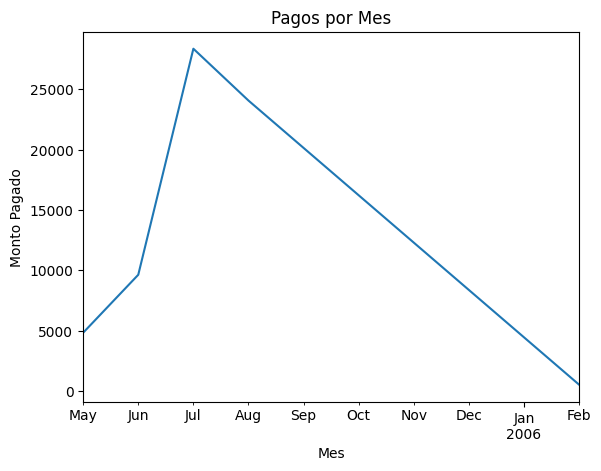

In [59]:
pagos_mes_df.plot()
plt.title('Pagos por Mes')
plt.xlabel('Mes')
plt.ylabel('Monto Pagado')

In [60]:
#duckdb_connection.sql("DELETE FROM Tbl_Alquiler;")
#duckdb_connection.sql("DELETE FROM TblDim_Cliente;")
#duckdb_connection.sql("DELETE FROM TblDim_Actores;")
#duckdb_connection.sql("DELETE FROM TblDim_Pelicula;")
#duckdb_connection.sql("DELETE FROM TblDim_Pagos;")

duckdb_connection.close()
staging_engine.dispose()